In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from itertools import compress
from scipy.io import loadmat

csv = '/media/elyall/EvanMHD/from_Amir/toEvan/6994/6994_210_000_exp_AnalysisInfo_14.csv'
csv = '/media/elyall/EvanMHD/from_Amir/toEvan/7736/7736_300_000_exp_AnalysisInfo_14.csv'
csv = '/media/elyall/EvanMHD/from_Amir/toEvan/7737/7737_291_000_exp_AnalysisInfo_14.csv'
data = pd.read_csv(csv)

pkl = '/media/elyall/EvanMHD/from_Amir/toEvan/6994/6994_tracings.pkl'
pkl = '/media/elyall/EvanMHD/from_Amir/toEvan/7736/7736_tracings.pkl'
pkl = '/media/elyall/EvanMHD/from_Amir/toEvan/7737/7737_tracings.pkl'
with open(pkl, 'rb') as f:
    tracings = pickle.load(f)

mat = loadmat('/media/elyall/EvanMHD/from_Amir/toEvan/7737/7737_291_000_exp_whisker_names.mat')

In [2]:
print(list(data.columns))

['StimID', 'TrialIndex', 'ExpFilename', 'DataFilename', 'nScans', 'ExpScans_1', 'ExpScans_2', 'ExpStimScans_1', 'ExpStimScans_2', 'ImgIndex', 'ImgFilename', 'nFrames', 'ExpFrames_1', 'ExpFrames_2', 'ExpStimFrames_1', 'ExpStimFrames_2', 'StimFrameLines_1', 'StimFrameLines_2', 'onlineRunSpeed', 'numRandomScansPost', 'WTStartScan_1', 'WTStartScan_2', 'WTStartScan_3', 'WTStartScan_4', 'WTStartScan_5', 'WTStartScan_6', 'WTStartScan_7', 'WTStartScan_8', 'WTStartScan_9', 'WTStartScan_10', 'WTStartScan_11', 'WTStartScan_12', 'WTStartScan_13', 'WTStartScan_14', 'WTStartScan_15', 'WTStartScan_16', 'WTStartScan_17', 'WTStartScan_18', 'WTStartScan_19', 'WTStartScan_20', 'WTStartScan_21', 'WTStartScan_22', 'WTStartScan_23', 'WTStartScan_24', 'WTStartScan_25', 'WTStartScan_26', 'WTStartScan_27', 'WTStartScan_28', 'WTStartScan_29', 'WTStartScan_30', 'WTStartScan_31', 'WTStartScan_32', 'WTStartScan_33', 'WTStartScan_34', 'WTStartScan_35', 'WTStartScan_36', 'WTStartScan_37', 'WTStartScan_38', 'WTStartS

In [3]:
# Compute mean number of touches per whisker
def avg_touches(data, index):
    num_touches = data[['num_touches_'+w for w in np.arange(1,6).astype('str')]]
    num_touches = num_touches[data['evan_trials_inliers']==True]
    mean = np.nanmean(num_touches, axis=0)
    n = np.sum(~np.isnan(num_touches), axis=0).values
    se = np.divide(1.96*np.nanstd(num_touches, axis=0), np.sqrt(n))
    return mean, se, num_touches

avg, se, num_touches = avg_touches(data, data['evan_trials_inliers'])

Text(0.5,0,'whisker')

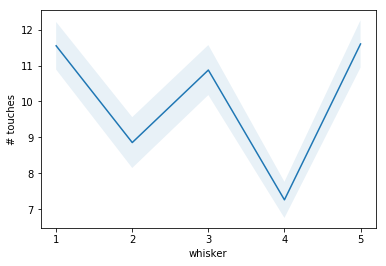

In [4]:
# Plot output
x = list(range(1,6))
# plt.violinplot(num_touches)
plt.plot(x, avg)
plt.fill_between(x, avg-se, avg+se, alpha=.1)
plt.xticks(x)
plt.ylabel('# touches')
plt.xlabel('whisker')

In [40]:
# Pull out angle
def gather_angle(tracings):
    num_frames = 10
    angle = [[] for _ in range(5)]
    for ind in np.arange(6): # whisker index
        for t in range(len(tracings[1])): # trial
            if ind in tracings[0]['touch'][t]: # whisker stimulated
                for f in tracings[0]['touch'][t][ind]: # touch event
                    angle[ind-1].append(tracings[0]['angle'][t][ind][f-num_frames:f+num_frames+1])
    num_frames = num_frames*2+1
    for ind in range(5):
        frames = np.array([len(x) for x in angle[ind]])
        angle[ind] = np.vstack(list(compress(angle[ind], frames==num_frames)))
    return angle, num_frames

# Compute mean of angle & its derivative
def avg_angle(angle, x):
    mean_angle = []
    se_angle = []
    mean_deriv = []
    se_deriv = []
    for a in angle:
        mean_angle.append(np.mean(a, axis=0))
        n, _ = np.shape(a)
        se_angle.append(1.96*np.nanstd(a, axis=0)/np.sqrt(n))
        deriv = np.gradient(a, x, axis=1)
        mean_deriv.append(np.mean(deriv, axis=0))
        se_deriv.append(1.96*np.nanstd(deriv, axis=0)/np.sqrt(n))
    return mean_angle, se_angle, mean_deriv, se_deriv
    
x = np.linspace(1/300,num_frames/300,num_frames)#*1000
angle, num_frames = gather_angle(tracings)
mean_angle, se_angle, mean_deriv, se_deriv = avg_angle(angle, x)
mean_angle = [m-np.mean(m) for m in mean_angle]
mean_angle = [m-m[0] for m in mean_angle]

Text(0,0.5,'delta angle (degrees/sec)')

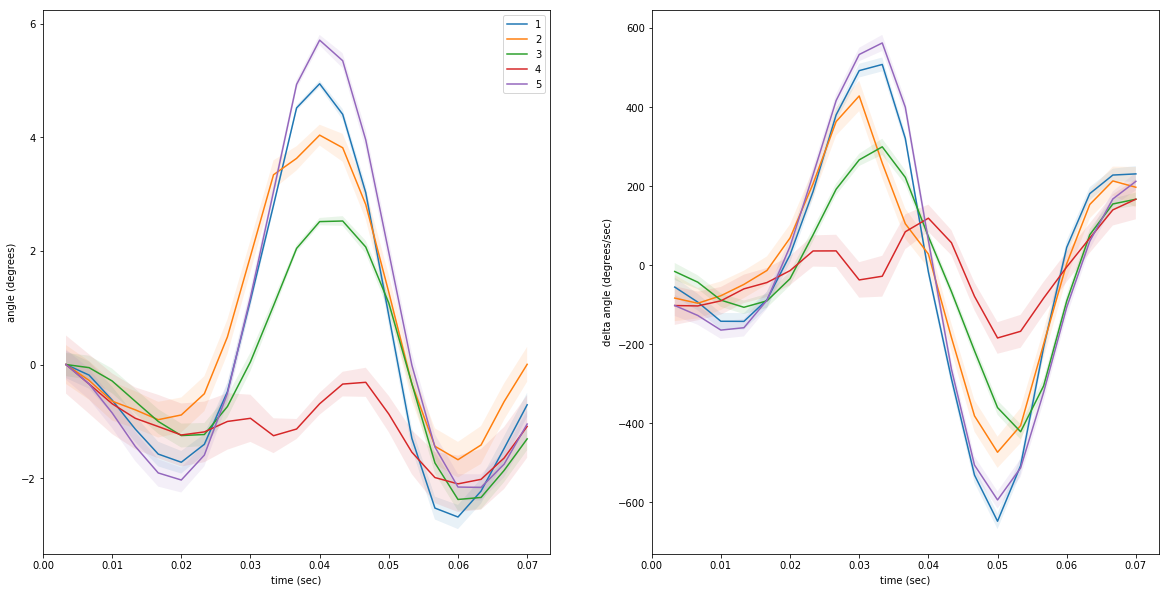

In [41]:
# Plot output
fig, ax = plt.subplots(1, 2, figsize=(20,10))
# ax = [ax,ax.twinx()]
for m, s1, d, s2 in zip(mean_angle, se_angle, mean_deriv, se_deriv):
    # ax[0].errorbar(x, m, s)
    ax[0].plot(x, m)
    ax[0].fill_between(x, m-s1, m+s1, alpha=0.1, antialiased=True)
    ax[1].plot(x, d)
    ax[1].fill_between(x, d-s2, d+s2, alpha=0.1, antialiased=True)
ax[0].set_ylabel('angle (degrees)')
[a.set_xlabel('time (sec)') for a in ax]
ax[0].legend(np.arange(1,6).astype('str'))
ax[1].set_ylabel('delta angle (degrees/sec)')